In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

In [2]:
def batchnorm_relu(inputs):
    """ Batch Normalization & ReLU """
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    return x

In [3]:
def residual_block(inputs, num_filters, strides=1):
    """ Convolutional Layers """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    """ Shortcut Connection (Identity Mapping) """
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    """ Addition """
    x = x + s
    return x

In [4]:
def decoder_block(inputs, skip_features, num_filters):
    """ Decoder Block """

    x = UpSampling2D((2, 2))(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters, strides=1)
    return x

In [5]:
def build_resunet(input_shape, num_classes):
    """ RESUNET Architecture """

    inputs = Input(input_shape)

    """ Endoder 1 """
    x = Conv2D(64, 3, padding="same", strides=1)(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(64, 3, padding="same", strides=1)(x)
    s = Conv2D(64, 1, padding="same")(inputs)
    s1 = x + s

    """ Encoder 2, 3 """
    s2 = residual_block(s1, 128, strides=2)
    s3 = residual_block(s2, 256, strides=2)

    """ Bridge """
    b = residual_block(s3, 512, strides=2)

    """ Decoder 1, 2, 3 """
    x = decoder_block(b, s3, 256)
    x = decoder_block(x, s2, 128)
    x = decoder_block(x, s1, 64)

    """ Classifier """
    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(x)

    """ Model """
    model = Model(inputs, outputs, name="RESUNET")

    return model

In [6]:
shape = (256, 256, 3)
model = build_resunet(shape,4)
model.summary()

Model: "RESUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
drive_path = '/content/drive/MyDrive/PFA' 

In [9]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision, Accuracy, IoU
from sklearn.model_selection import train_test_split

In [10]:
H = 256
W = 256

def create_dir(path):
    """Create a directory"""
    if not os.path.exists(path):
        os.mkdir(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path):
    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/label/*.bmp"))
    
    print(len(masks), len(images))

    train_x, valid_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=0.2, random_state=42)
    print(len(train_x), len(train_y), len(valid_x), len(valid_y))
   
    return (train_x, train_y), (valid_x, valid_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode('utf-8')
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x[x == 255] = 0
    x[x == 223] = 1 #ZP
    x[x == 127] = 2 #TE
    x[x == 191] = 3 #ICM
    x[ x > 3] = 0
    x = x.astype(np.int32)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.int32])
    y = tf.one_hot(y, 4, dtype=tf.int32)
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 4])

    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)

    return dataset

In [11]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [12]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("/content/drive/MyDrive/PFA/files_resunet")

"""Hyperparameters"""
batch_size = 10
learning_rate = 1e-4
num_epochs = 30
model_path = os.path.join("/content/drive/MyDrive/PFA/files_resunet", "model.h5")
csv_path = os.path.join("/content/drive/MyDrive/PFA/files_resunet", "data.csv")

"""Dataset"""
dataset_path = os.path.join("/content/drive/MyDrive/PFA/new_data")
train_path = os.path.join(dataset_path, "train")

(train_x, train_y), (valid_x, valid_y) = load_data(train_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
test_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

"""Model"""

model = build_resunet((H, W, 3),4)
metrics = [dice_coef, iou, 'accuracy', Recall(), Precision()]
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate), metrics=metrics)

train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=num_epochs,
    validation_data=test_dataset,
    validation_steps=valid_steps,
    callbacks=callbacks
)

945 945
756 756 189 189
Train: 756 - 756
Valid: 189 - 189
Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 0.6996 - dice_coef: 0.7590 - iou: 0.6160 - accuracy: 0.7866 - recall: 0.7814 - precision: 0.7926
Epoch 1: val_loss improved from inf to 2.08368, saving model to /content/drive/MyDrive/PFA/files_resunet/model.h5
75/75 [==============================] - 230s 3s/step - loss: 0.6996 - dice_coef: 0.7590 - iou: 0.6160 - accuracy: 0.7866 - recall: 0.7814 - precision: 0.7926 - val_loss: 2.0837 - val_dice_coef: 0.6748 - val_iou: 0.5099 - val_accuracy: 0.6812 - val_recall: 0.6812 - val_precision: 0.6812 - lr: 1.0000e-04
Epoch 2/30
75/75 [==============================] - ETA: 0s - loss: 0.3993 - dice_coef: 0.8045 - iou: 0.6732 - accuracy: 0.8413 - recall: 0.8350 - precision: 0.8477
Epoch 2: val_loss did not improve from 2.08368
75/75 [==============================] - 128s 2s/step - loss: 0.3993 - dice_coef: 0.8045 - iou: 0.6732 - accuracy: 0.8413 - recall: 0.8350 - preci

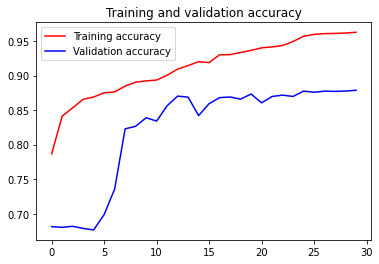

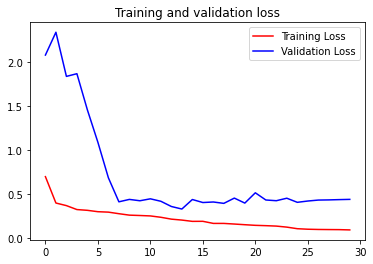

In [13]:
# Plot the chart for accuracy and loss on both training and validation
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
def load_data(path):

    images = sorted(glob(f"{path}/ROI/*.bmp"))
    masks = sorted(glob(f"{path}/label/*.bmp"))
    
    print(len(images), len(masks))
   
    return (images, masks)
    
test_path = os.path.join(dataset_path, "test")
(test_x, test_y) = load_data(test_path)

48 48


In [15]:
from tqdm import tqdm

In [16]:
num_classes = 4
res_path = os.path.join(dataset_path, "results_resunet")
create_dir(res_path)
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ## Read image
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        x = x / 255.0
        x = x.astype(np.float32)
        
        ## Read mask
        y = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        y[y == 255] = 0
        y[y == 223] = 1 #ZP
        y[y == 127] = 2 #TE
        y[y == 191] = 3 #ICM
        y[ y > 3] = 0
        y = np.expand_dims(y, axis=-1) ## (256, 256, 1)
        y = y * (255/num_classes)
        y = y.astype(np.int32)
        y = np.concatenate([y, y, y], axis=2)

        ## Prediction
        p = model.predict(np.expand_dims(x, axis=0))[0]
        p = np.argmax(p, axis=-1)
        p = np.expand_dims(p, axis=-1)
        p = p * (255/num_classes)
        p = p.astype(np.int32)
        p = np.concatenate([p, p, p], axis=2)

        x = x * 255.0
        x = x.astype(np.int32)

        h, w, _ = x.shape
        line = np.ones((h, 10, 3)) * 255

        

        final_image = np.concatenate([x, line, y, line, p], axis=1)
        status = cv2.imwrite(f"{res_path}/{name}", final_image)
        

100%|██████████| 48/48 [00:39<00:00,  1.21it/s]
